# Pacoes e classes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from funcoes.buscar_dados import Temperature, Load
from funcoes.equacoes import  tabela_equacoes, tabela_metricas
from funcoes.graficos import plotar_graficos, grid_graficos, grid_graficos_estacoes
from funcoes.estacao_ano import estacao_do_ano
from funcoes.farenheit_celsius import trocar_temp
import gridstatus as gs
from gridstatus import Ercot
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
# df = pd.read_excel('C:/Users/joao.pinheiro/repos/tcc-serena/dados/tempeture_load.xlsx')
# df.columns = ['interval_start_utc', 'interval_end_utc','publish_time_utc',
#         'Unnamed', 'coast_carga', 'east_carga', 'far_west_carga', 'north_carga', 'north_central_carga',
#         'south_central_carga', 'southern_carga', 'west_carga', 'sum_load', 'weekday', 'hour',
#         'coast_tf', 'east_tf', 'far_west_tf', 'north_tf', 'north_central_tf',
#         'south_central_tf', 'southern_tf', 'west_tf', 'avg_temp_fahrenheit']

# df1 = df.copy()

In [3]:
# colunas_fahrenheit = ['coast_tf',
#                         'east_tf',
#                         'far_west_tf',
#                         'north_tf',
#                         'north_central_tf',
#                         'south_central_tf',
#                         'southern_tf',
#                         'west_tf',
#                         'avg_temp_fahrenheit']

# for col in colunas_fahrenheit:
#     if col == 'avg_temp_fahrenheit':
#         nova_col = 'avg_temp_celsius'
#     else:
#         nova_col = col.replace('_tf', '_tc')
#     df1[nova_col] = (df1[col] - 32) * (5 / 9)

In [4]:
# plotar_graficos(df = df1, hour= 8, weekday=0)

# Utilizando classes

In [5]:
# credencias
api_key = '41ac637ac7464f6da57351ed3fa5e5ff'
start_date = "2023-09-01"
end_date = "2024-09-01"

In [6]:
# !!!!!!!!!!!!!!!!!!!!!!! aumentar horizonte de tempo

# # Temperatura
# temp = Temperature(api_key)
# df_temp = temp.get_df_temp(start_date, end_date)

# # Carga
# load = Load(api_key)
# df_load = load.get_df_load(start_date, end_date)


# df_temp.to_csv('df_temp.csv')
# df_load.to_csv('df_load.csv')

# Lendo arquivos baixados pela api
filtrar de 2023/09 até 2024/09 todas as horas da carga

In [7]:
# df_t = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_temp.csv')
# df_l = pd.read_csv('C:/Users/joao.pinheiro/OneDrive - Serena/Área de Trabalho/df_load.csv')

df_t = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_temp.csv')
df_l = pd.read_csv('C:/Users/Computadores Gamer/OneDrive/Área de Trabalho/dados_tcc/df_load.csv')

In [8]:
# Tratamentos iniciais
for df in [df_l, df_t]:
    df["interval_start_utc"] = pd.to_datetime(df["interval_start_utc"]).dt.tz_localize(None)
    df["interval_end_utc"] = pd.to_datetime(df["interval_end_utc"], utc=True).dt.tz_localize(None)
    df["publish_time_utc"] = pd.to_datetime(df["publish_time_utc"], utc=True).dt.tz_localize(None)
    
df_t = df_t.drop(columns=["Unnamed: 0"], errors="ignore")
df_l = df_l.drop(columns=["Unnamed: 0", "publish_time_utc_load",'publish_time_utc_tf'], errors="ignore")


df_t = df_t[['interval_start_utc', 'interval_end_utc', 'publish_time_utc', 'coast',
        'east', 'far_west', 'north', 'north_central', 'south_central',
        'southern', 'west', 'hour', 'weekday', 'avg_temp_fahrenheit']]


In [9]:
df = pd.merge(
    df_l,
    df_t,
    on=["interval_start_utc", "interval_end_utc"],
    how="inner",
    suffixes=['_carga','_tf']
)

df = trocar_temp(df)
df['publish_time_utc_carga'] = pd.to_datetime(df['publish_time_utc_carga'])


hora = dt.time(10, 30) 
df = df[(df['publish_time_utc_carga'].dt.time == hora)]


# Qual dia da semana

In [10]:
df_dia_semana = df.copy()
df_dia_semana['dia'] = pd.to_datetime(df_dia_semana['publish_time_utc_carga'])
df_dia_semana['dia'] = df_dia_semana['publish_time_utc_carga'].dt.day_name()
df_dia_semana['ano']= df_dia_semana['publish_time_utc_carga'].dt.year
df_dia_semana['mes']= df_dia_semana['publish_time_utc_carga'].dt.month

df_dia_semana.replace([np.inf, -np.inf], np.nan, inplace=True)
df_dia_semana['estacao'] = df_dia_semana['publish_time_utc_carga'].apply(estacao_do_ano)
df_dia_semana.head()


,interval_start_utc,interval_end_utc,publish_time_utc_carga,coast_carga,east_carga,far_west_carga,north_carga,north_central_carga,south_central_carga,southern_carga,...,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc,avg_temp_celsius,dia,ano,mes,estacao
5,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-24 10:30:00,15754.7002,2592.1499,6031.5200,1995.6801,24349.1992,12124.0000,5415.6201,...,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583,Thursday,2023,8,verao
53,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-26 10:30:00,18833.6992,2536.3701,6121.2700,1964.8101,23720.3008,11504.2002,5688.4502,...,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583,Saturday,2023,8,verao
101,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-28 10:30:00,18314.1992,2559.4700,6163.2202,1949.4399,23442.6992,13311.9004,5669.0898,...,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583,Monday,2023,8,verao
149,2023-08-31 19:00:00,2023-09-01 01:00:00,2023-08-30 10:30:00,18665.6992,2535.8701,6106.0200,1941.1899,22746.0000,13618.9004,5630.3999,...,33.888889,35.694444,36.944444,33.888889,37.000000,34.989583,Wednesday,2023,8,verao
197,2023-08-31 20:00:00,2023-09-01 02:00:00,2023-08-24 10:30:00,15446.0996,2471.0100,5940.2100,1921.5000,23334.5996,11676.4004,5266.2998,...,31.388889,33.055556,34.444444,31.666667,34.888889,32.875000,Thursday,2023,8,verao


# Gráficos de Carga média

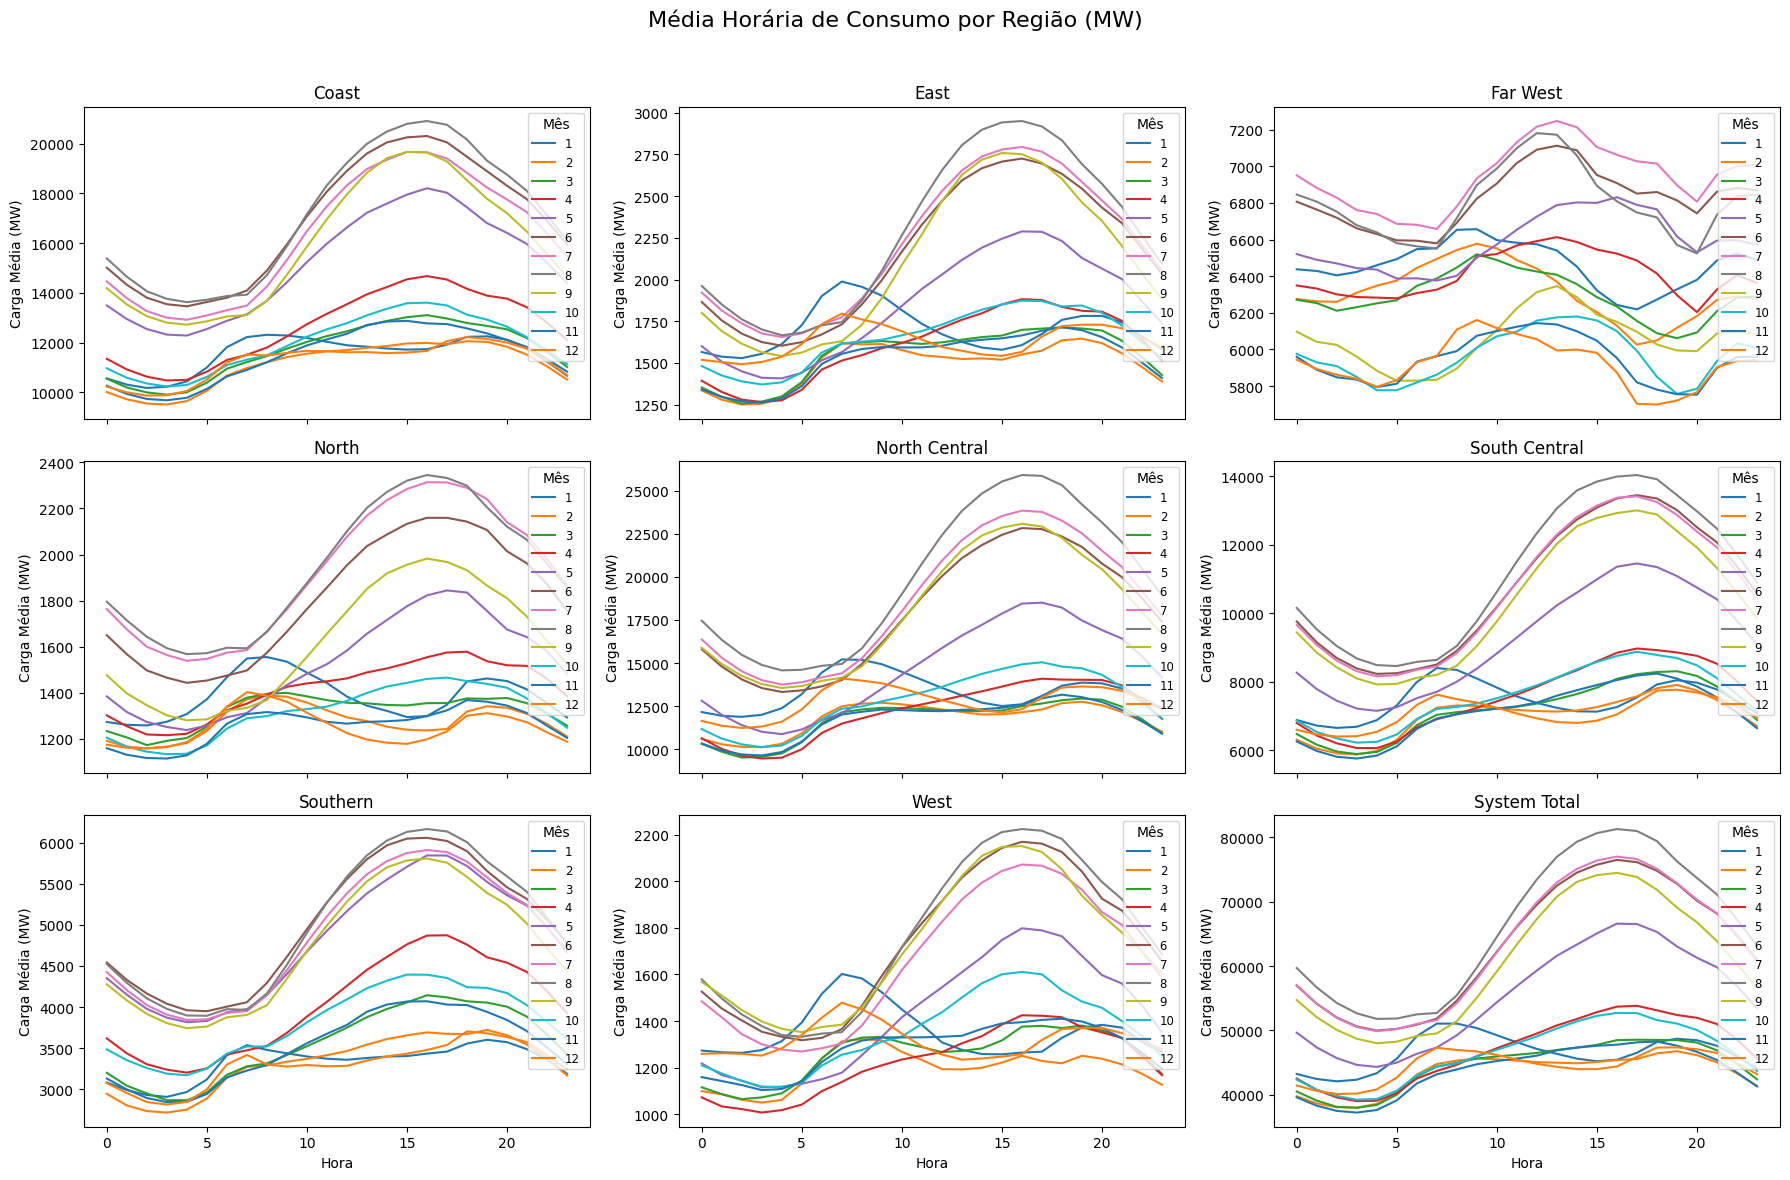

In [11]:
# Lista com os nomes das 9 regiões (colunas de carga)
regioes = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True, sharey=False)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes):
    df_regiao = df_dia_semana.groupby(['mes', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='mes',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga Média (MW)')
    axes[i].legend(title='Mês', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Consumo por Região (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Gráficos de temperatura média

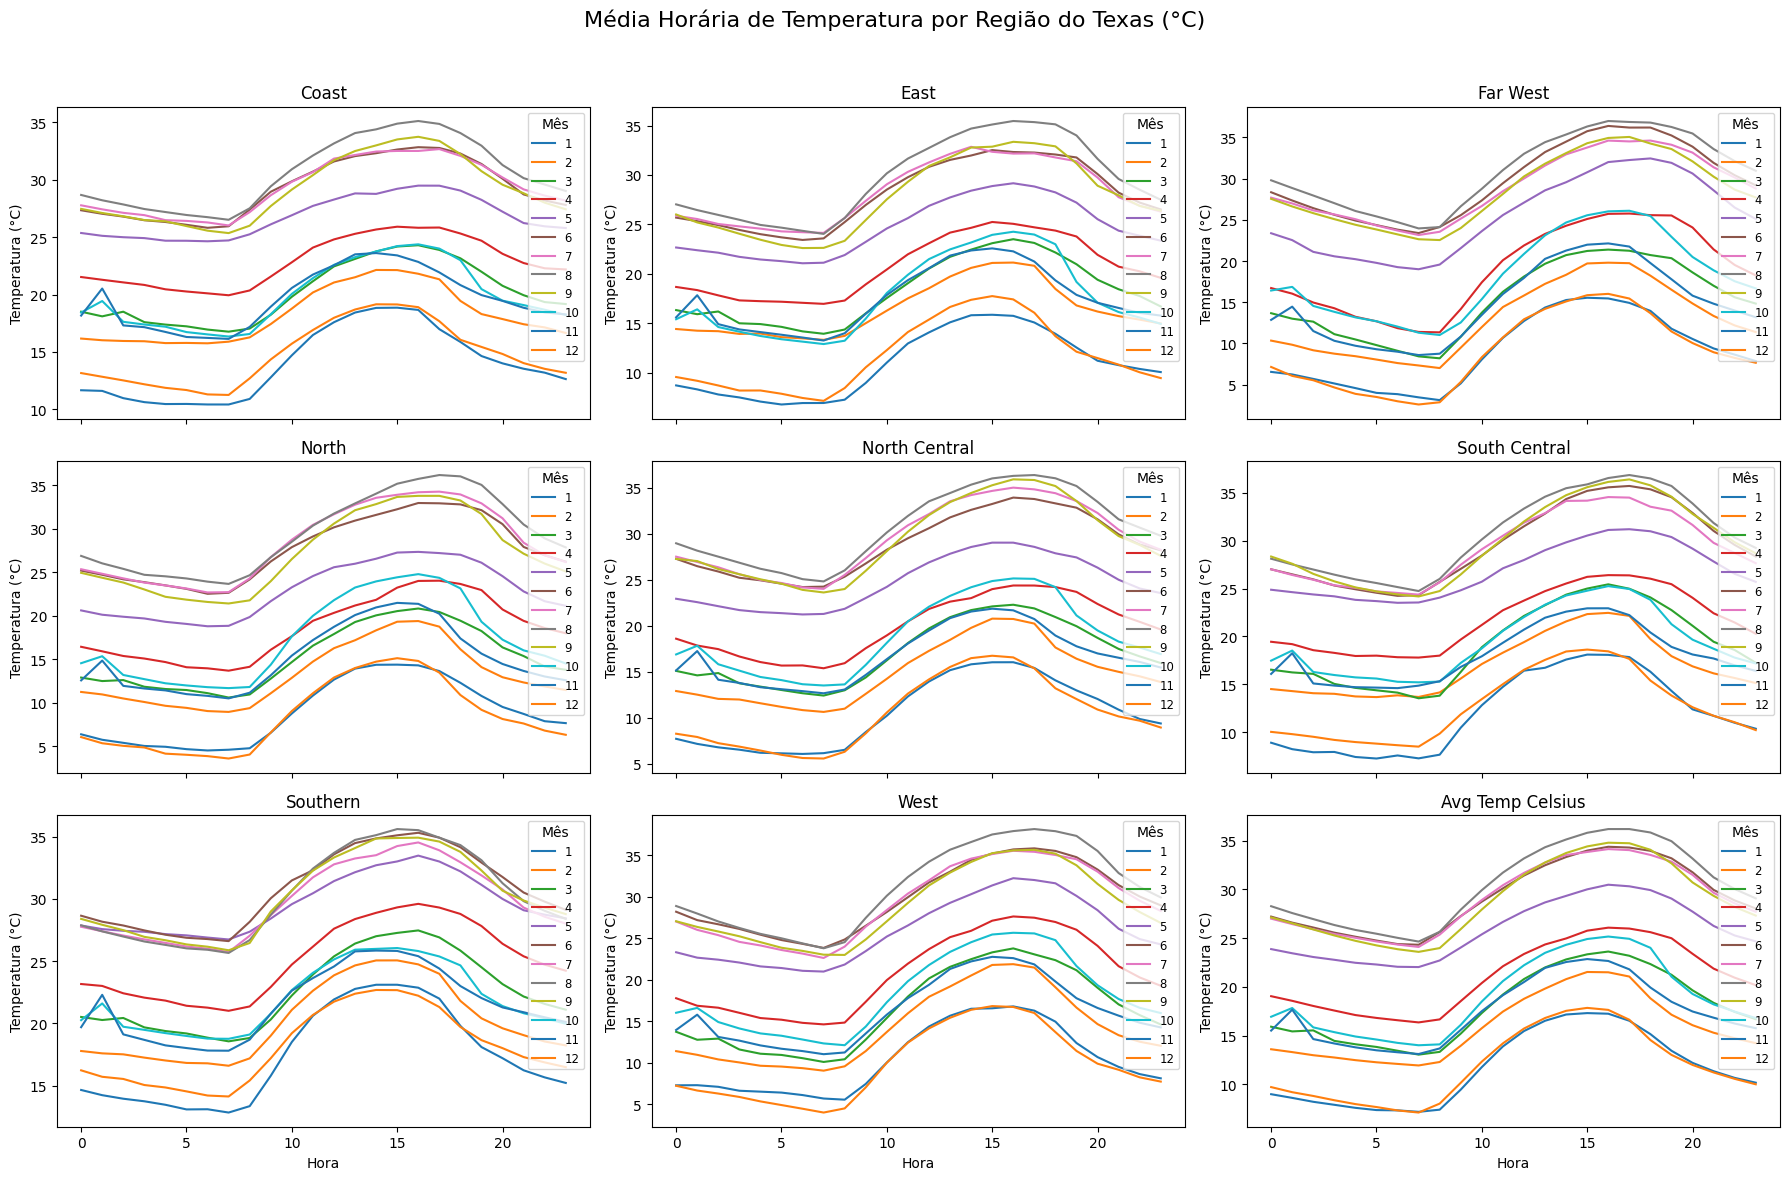

In [12]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius']

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True) 
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['mes', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='mes',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (°C)')
    axes[i].legend(title='Mês', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Temperatura por Região do Texas (°C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Graficos de temperatura por estacao do ano

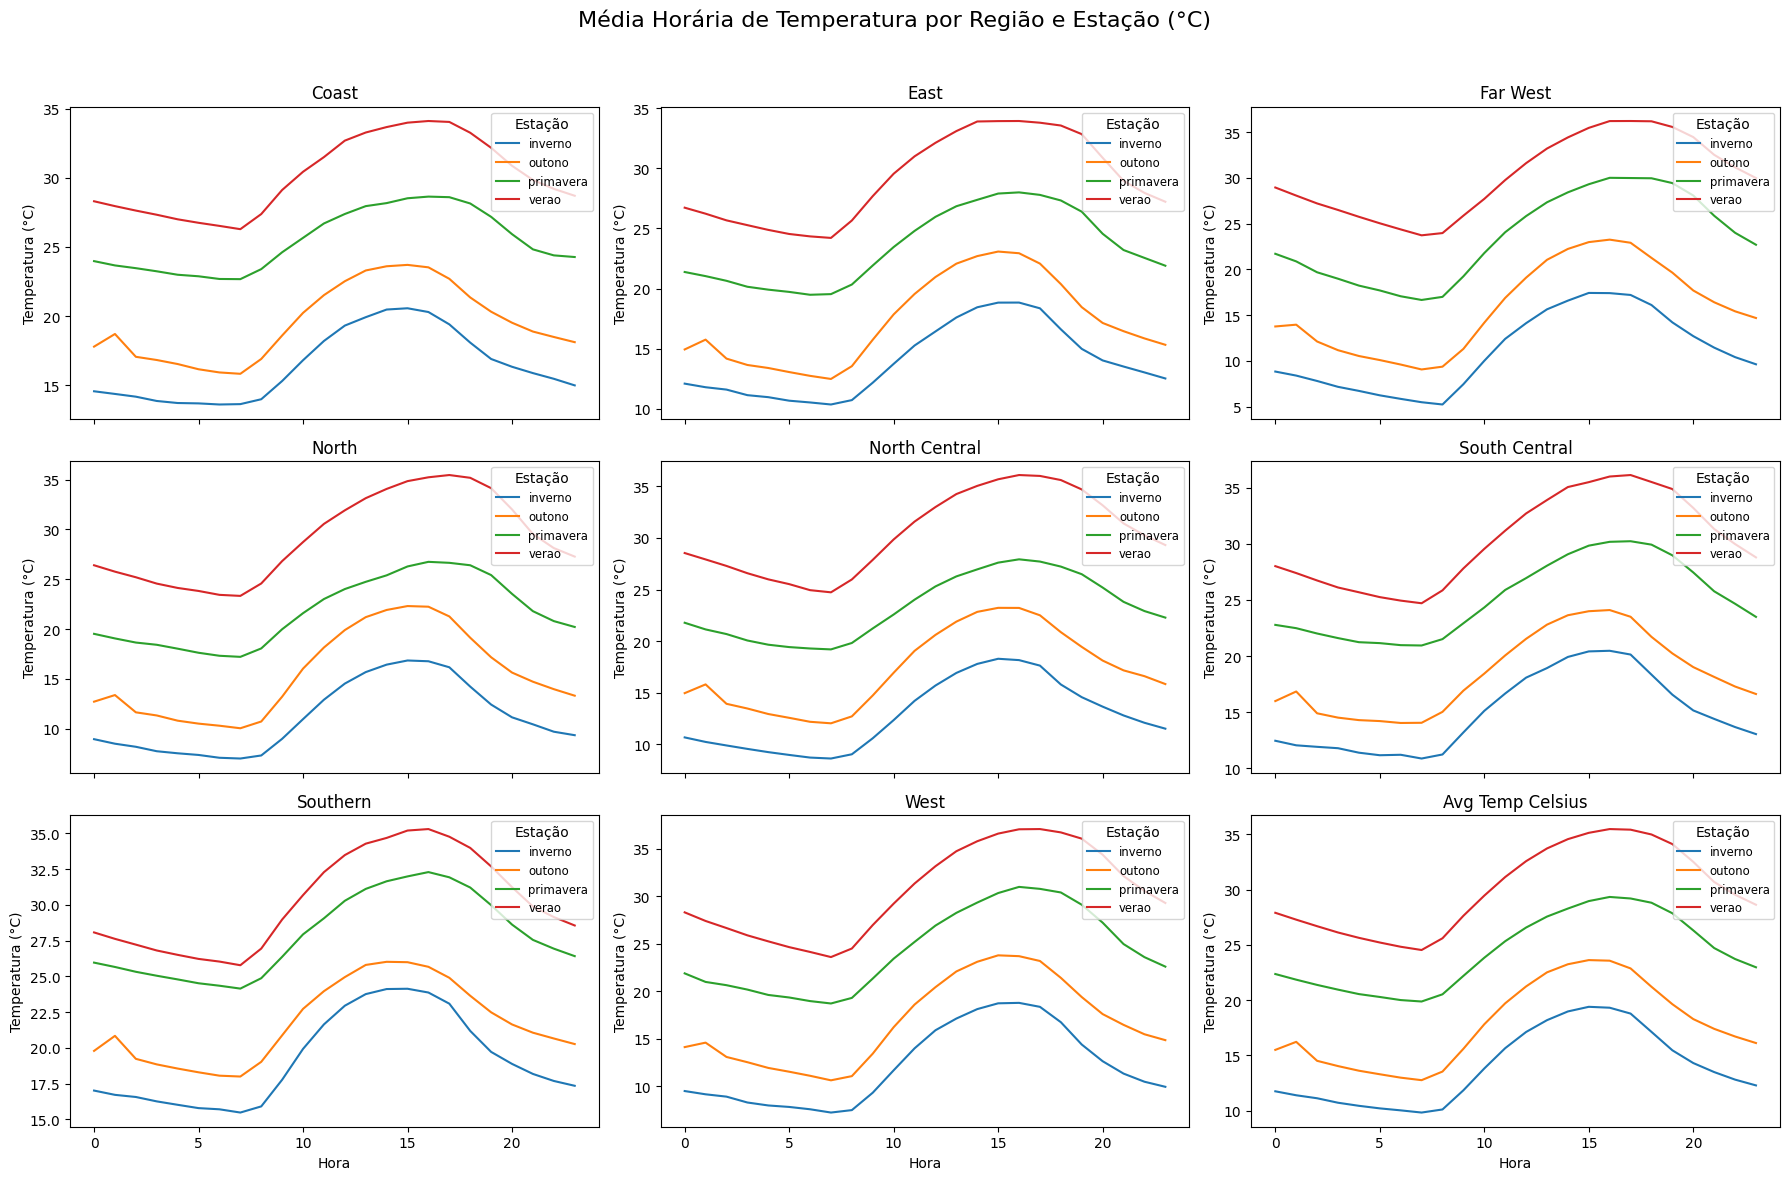

In [13]:
# Lista apenas com colunas de temperatura em Celsius
regioes_tc = [
    'coast_tc', 'east_tc', 'far_west_tc',
    'north_tc', 'north_central_tc', 'south_central_tc',
    'southern_tc', 'west_tc', 'avg_temp_celsius'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_tc):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_tc', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Temperatura (°C)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Temperatura por Região e Estação (°C)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()



# Graficos de carga por estacao do ano

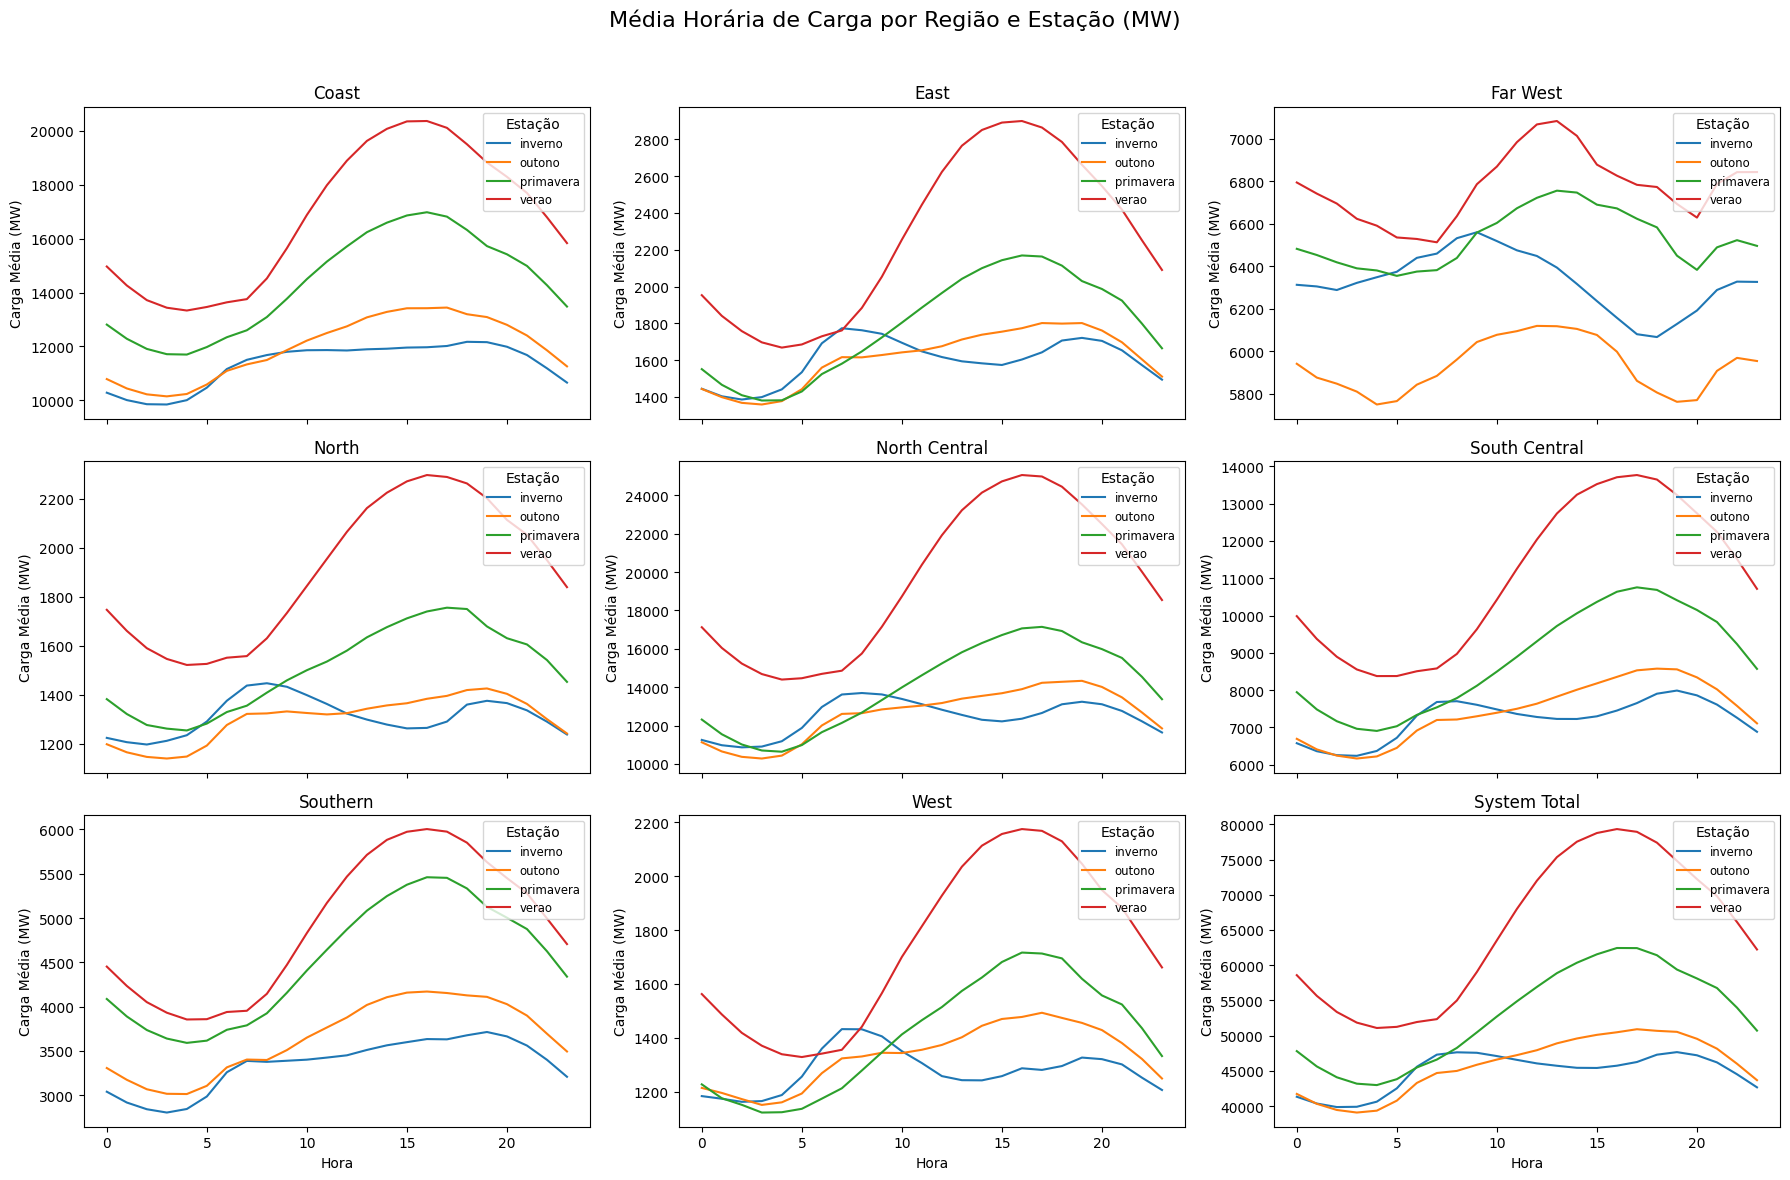

In [14]:
# Lista com os nomes das 9 regiões (colunas de carga)
regioes_carga = [
    'coast_carga', 'east_carga', 'far_west_carga',
    'north_carga', 'north_central_carga', 'south_central_carga',
    'southern_carga', 'west_carga', 'system_total'
]

# Configura figura 3x3
fig, axes = plt.subplots(3, 3, figsize=(18, 12), sharex=True)
axes = axes.flatten()

# Criar gráfico para cada região
for i, regiao in enumerate(regioes_carga):
    df_regiao = df_dia_semana.groupby(['estacao', 'hour'])[regiao].mean().reset_index()

    sns.lineplot(
        data=df_regiao,
        x='hour',
        y=regiao,
        hue='estacao',
        palette='tab10',
        ax=axes[i]
    )
    
    # Títulos e estética
    nome_formatado = regiao.replace('_carga', '').replace('_', ' ').title()
    axes[i].set_title(f'{nome_formatado}')
    axes[i].set_xlabel('Hora')
    axes[i].set_ylabel('Carga Média (MW)')
    axes[i].legend(title='Estação', fontsize='small', loc='upper right')

# Ajustes finais
plt.suptitle('Média Horária de Carga por Região e Estação (MW)', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


# Comparativo entre temperatura vs carga ambos por estacao

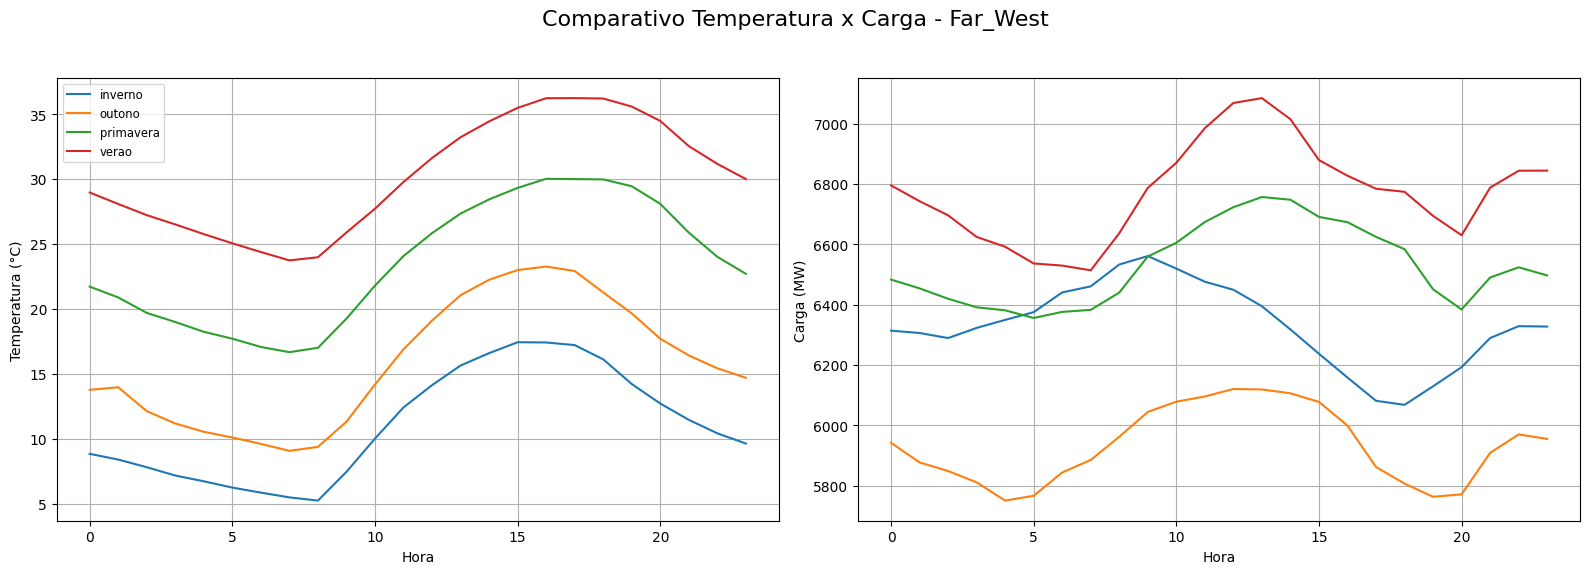

In [15]:
def comparar_temp_carga_estacoes(df, regiao_tc):
    regiao_nome = regiao_tc.replace('_tc', '')
    regiao_carga = f'{regiao_nome}_carga'

    # Agrupar dados por estação e hora
    df_temp = df.groupby(['estacao', 'hour'])[regiao_tc].mean().reset_index()
    df_carga = df.groupby(['estacao', 'hour'])[regiao_carga].mean().reset_index()

    estacoes = sorted(df['estacao'].dropna().unique())

    # Criar figura com 2 subplots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

    # --- Gráfico de Temperatura ---
    sns.lineplot(data=df_temp, x='hour', y=regiao_tc, hue='estacao', palette='tab10', ax=axs[0])
    # axs[0].set_title(f'Temperatura por Estação - {regiao_nome.title()}')
    axs[0].set_xlabel('Hora')
    axs[0].set_ylabel('Temperatura (°C)')
    axs[0].grid(True)

    # --- Gráfico de Carga ---
    sns.lineplot(data=df_carga, x='hour', y=regiao_carga, hue='estacao', palette='tab10',dashes=True, ax=axs[1])
    # axs[1].set_title(f'Carga por Estação - {regiao_nome.title()}')
    axs[1].set_xlabel('Hora')
    axs[1].set_ylabel('Carga (MW)')
    axs[1].grid(True)

    # Ajuste da legenda
    axs[1].legend_.remove()  # Remove legenda duplicada
    axs[0].legend( fontsize='small')

    # Layout final
    plt.suptitle(f'Comparativo Temperatura x Carga - {regiao_nome.title()}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


comparar_temp_carga_estacoes(df_dia_semana, 'far_west_tc')

In [16]:
tabela_equacoes(df = df , n_weekday = 1 )

,Hora,avg_temp_celsius,coast_tc,east_tc,far_west_tc,north_tc,north_central_tc,south_central_tc,southern_tc,west_tc
0,0,y = 89.36x² -2424.62x + 55507.53,y = 25.74x² -737.48x + 15144.30,y = 3.50x² -101.87x + 2086.66,y = 2.14x² -52.82x + 6473.50,y = 2.19x² -48.88x + 1436.16,y = 29.17x² -807.08x + 15670.57,y = 16.20x² -423.32x + 8838.45,y = 9.16x² -287.16x + 5187.07,y = 1.95x² -53.86x + 1466.04
1,1,y = 89.65x² -2440.69x + 54394.81,y = 24.83x² -715.94x + 14761.71,y = 3.30x² -96.25x + 2002.96,y = 2.20x² -52.84x + 6439.73,y = 2.12x² -47.71x + 1405.28,y = 29.53x² -821.44x + 15325.52,y = 15.90x² -414.88x + 8500.17,y = 9.18x² -287.08x + 5048.38,y = 2.00x² -56.14x + 1460.57
2,2,y = 88.05x² -2391.05x + 53296.77,y = 23.05x² -653.19x + 14054.07,y = 3.32x² -98.18x + 1993.72,y = 2.10x² -46.66x + 6362.85,y = 2.11x² -47.76x + 1383.65,y = 28.97x² -802.85x + 14956.93,y = 15.37x² -402.99x + 8339.19,y = 8.79x² -274.18x + 4868.89,y = 1.96x² -55.03x + 1435.67
3,3,y = 87.43x² -2365.74x + 52880.95,y = 22.58x² -639.24x + 13937.15,y = 3.25x² -96.84x + 1980.81,y = 1.99x² -42.78x + 6319.51,y = 2.05x² -46.71x + 1380.41,y = 29.54x² -813.88x + 14892.72,y = 14.85x² -390.29x + 8254.68,y = 8.56x² -265.23x + 4763.10,y = 1.95x² -54.87x + 1424.98
4,4,y = 87.37x² -2371.47x + 53486.75,y = 21.92x² -619.26x + 13980.40,y = 3.26x² -98.64x + 2034.75,y = 1.98x² -41.48x + 6295.49,y = 2.05x² -46.83x + 1392.46,y = 29.03x² -803.35x + 15059.83,y = 14.02x² -368.99x + 8242.93,y = 8.79x² -277.89x + 4934.11,y = 1.94x² -54.96x + 1437.70
5,5,y = 87.18x² -2406.62x + 55868.94,y = 22.07x² -636.67x + 14735.61,y = 3.24x² -100.47x + 2147.52,y = 1.85x² -39.58x + 6306.06,y = 1.91x² -44.66x + 1446.71,y = 28.97x² -818.37x + 15980.37,y = 13.09x² -350.17x + 8558.41,y = 8.40x² -268.61x + 5037.75,y = 1.83x² -53.15x + 1482.30
6,6,y = 82.09x² -2335.92x + 59186.51,y = 20.27x² -596.45x + 15296.55,y = 2.92x² -95.19x + 2298.57,y = 1.62x² -35.68x + 6374.58,y = 1.78x² -43.38x + 1543.62,y = 26.40x² -769.20x + 17075.07,y = 12.63x² -359.13x + 9401.66,y = 7.64x² -250.78x + 5266.55,y = 1.69x² -52.10x + 1590.34
7,7,y = 80.11x² -2305.72x + 60753.66,y = 21.27x² -639.93x + 16021.37,y = 2.84x² -93.57x + 2351.84,y = 1.35x² -28.75x + 6364.89,y = 1.74x² -44.00x + 1601.57,y = 26.33x² -785.00x + 17924.60,y = 11.45x² -329.77x + 9583.37,y = 7.85x² -263.92x + 5540.03,y = 1.54x² -48.49x + 1625.83
8,8,y = 84.08x² -2412.44x + 61668.18,y = 22.56x² -688.51x + 16590.44,y = 3.09x² -99.07x + 2377.52,y = 2.07x² -47.89x + 6509.62,y = 1.79x² -43.72x + 1598.21,y = 26.39x² -776.50x + 17912.06,y = 14.29x² -419.30x + 10168.87,y = 8.63x² -293.52x + 5768.59,y = 1.53x² -44.37x + 1588.26
9,9,y = 87.84x² -2650.48x + 65128.78,y = 23.22x² -732.82x + 17390.56,y = 3.58x² -119.22x + 2592.76,y = 2.05x² -48.85x + 6611.81,y = 1.86x² -47.55x + 1642.21,y = 28.12x² -861.02x + 19000.34,y = 18.12x² -578.57x + 11696.81,y = 9.10x² -324.64x + 6227.02,y = 1.70x² -49.66x + 1644.41


In [17]:
tabela_metricas(df, 1)

,Hora,avg_temp_celsius_R2,avg_temp_celsius_RMSE,coast_tc_R2,coast_tc_RMSE,east_tc_R2,east_tc_RMSE,far_west_tc_R2,far_west_tc_RMSE,north_tc_R2,north_tc_RMSE,north_central_tc_R2,north_central_tc_RMSE,south_central_tc_R2,south_central_tc_RMSE,southern_tc_R2,southern_tc_RMSE,west_tc_R2,west_tc_RMSE
0,0,0.928,2128.42,0.866,791.77,0.696,151.12,0.428,302.92,0.729,136.35,0.891,950.34,0.876,548.72,0.905,204.33,0.752,104.72
1,1,0.919,2040.90,0.856,754.90,0.652,151.71,0.373,319.41,0.671,138.75,0.873,935.30,0.856,532.83,0.899,198.95,0.677,111.57
2,2,0.910,1965.70,0.844,725.04,0.636,148.12,0.350,317.64,0.650,130.63,0.852,930.31,0.826,531.49,0.891,194.99,0.622,110.76
3,3,0.897,1943.29,0.830,718.52,0.643,140.39,0.295,322.87,0.601,130.18,0.838,909.35,0.782,545.29,0.887,185.63,0.591,108.93
4,4,0.879,1960.28,0.812,715.20,0.647,135.32,0.241,350.46,0.585,124.91,0.811,926.84,0.752,537.61,0.883,175.48,0.542,108.23
5,5,0.846,2038.43,0.787,716.31,0.660,131.19,0.175,351.23,0.516,126.14,0.763,975.99,0.682,562.20,0.864,169.88,0.471,110.61
6,6,0.772,2206.52,0.720,739.77,0.642,134.09,0.119,333.10,0.425,128.63,0.675,1055.39,0.596,567.99,0.801,176.83,0.404,116.98
7,7,0.724,2338.30,0.711,732.92,0.622,140.76,0.083,327.95,0.391,130.30,0.659,1060.99,0.523,595.22,0.781,173.20,0.369,127.99
8,8,0.810,2181.76,0.785,732.88,0.637,132.08,0.157,329.70,0.469,132.92,0.713,1017.33,0.690,512.15,0.872,157.61,0.331,121.74
9,9,0.874,2197.69,0.822,815.07,0.748,118.38,0.214,332.66,0.590,135.74,0.787,1023.11,0.852,428.29,0.898,178.74,0.481,118.69


# Grid de gráficos por regiao e parametrizando uma hora por vez

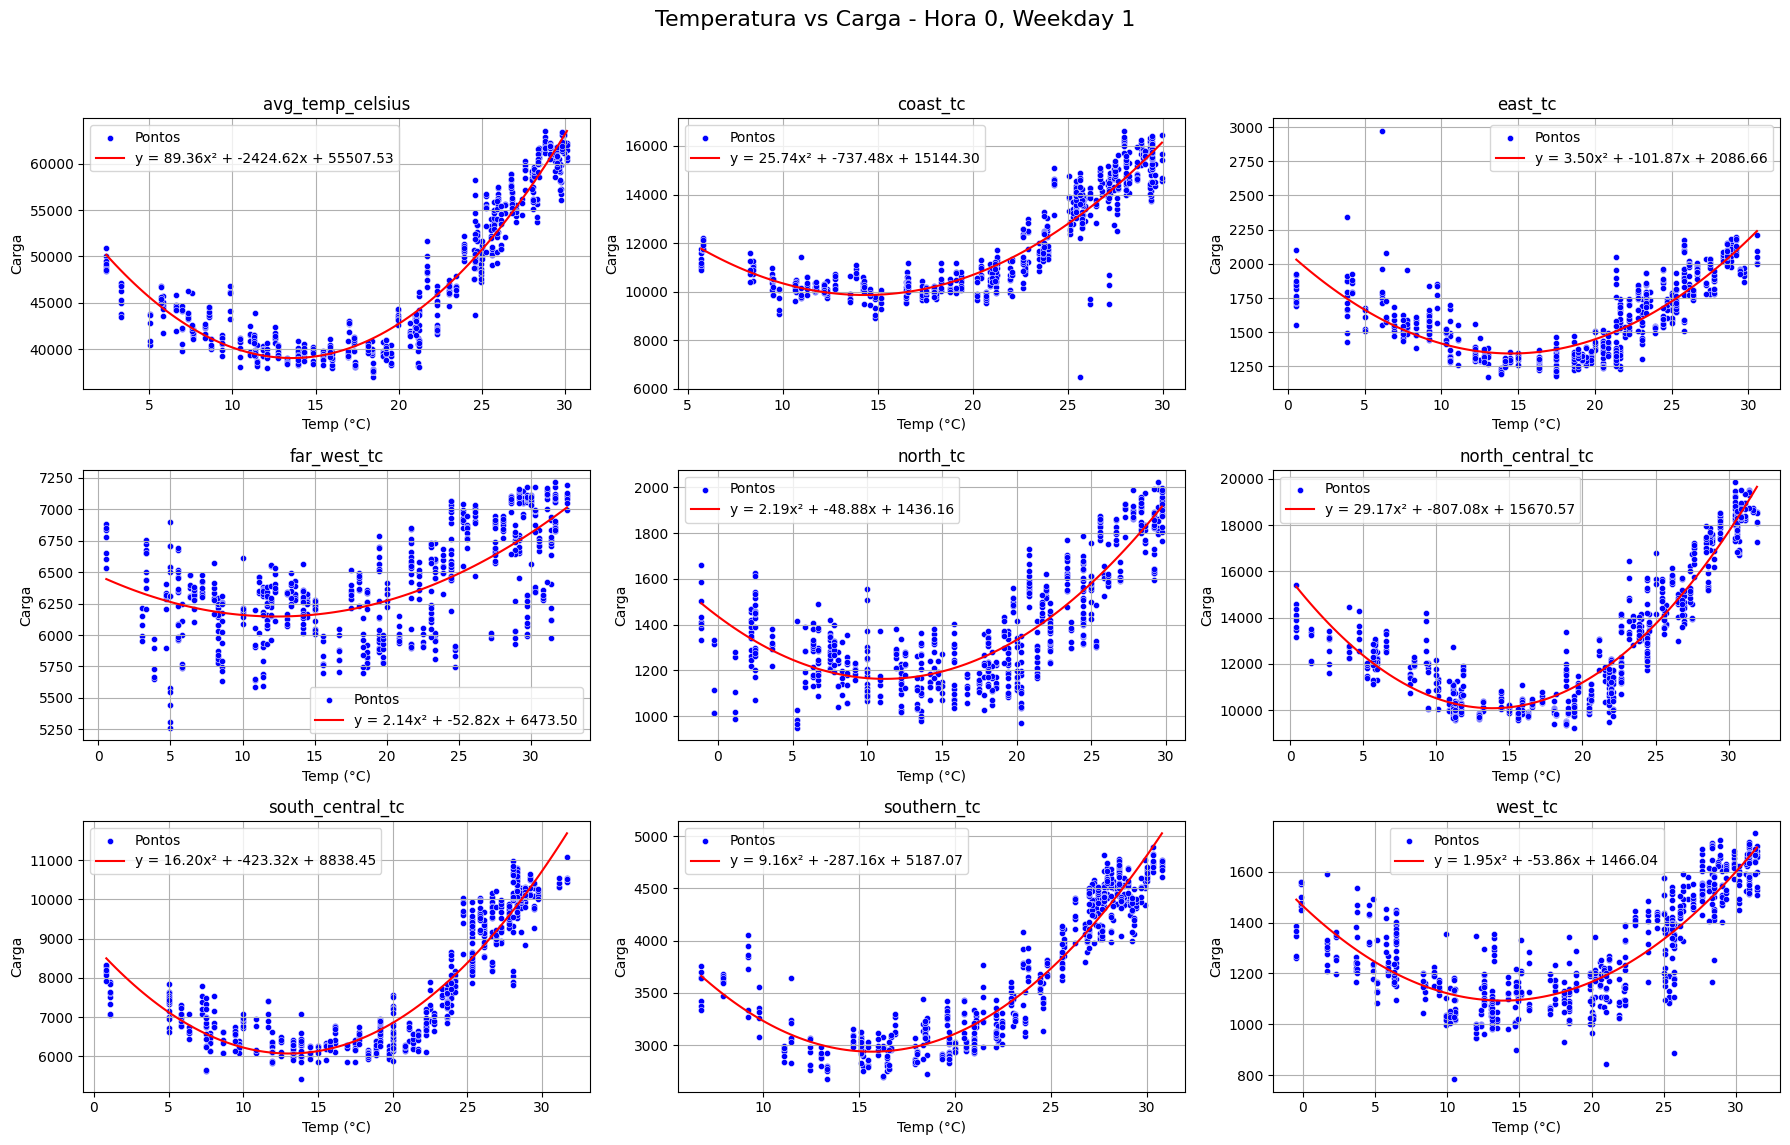

In [18]:
grid_graficos(df= df, hour=0, weekday= 1)

# teste 1
- treinamento com a carga total vs media simples temperatura do estado
- usando regressão linear com Mínimos Quadrados Ordinários
- PolynomialFeatures(degree=2), dados com termos quadráticos

- Você transforma a variável X (temperatura média) em: 
    1 (termo constante)

    X (linear)

    X² (quadrático)

- Depois ajusta a equação do tipo:
 y_hat = 𝛽0 + 𝛽1X + 𝛽2X²

-  E os coeficientes 𝛽 são estimados por MQO

Região: Coast - Hora: 14 - Weekday: 1
Equação: y = 22.04x² + -630.30x + 16113.00
RMSE: 1523.89
R²: 0.825


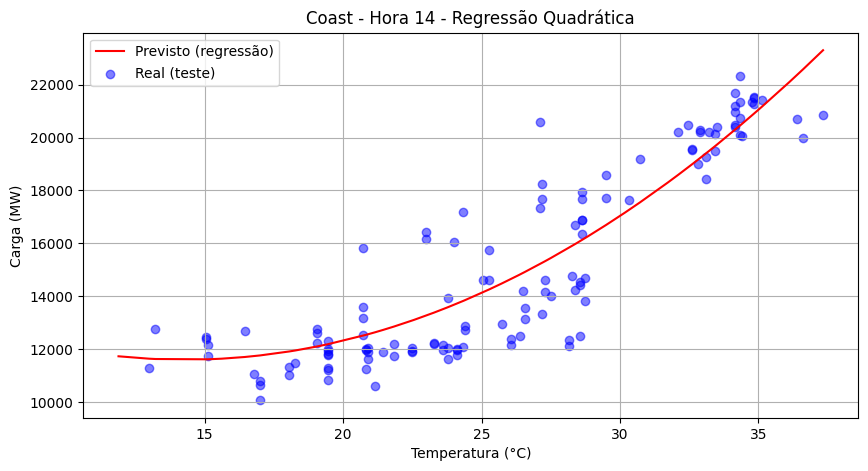

In [22]:
def ajustar_e_plotar_regressao(df, regiao='coast', hora=14, weekday=1, plot_tudo=True):
    temp_col = f"{regiao}_tc"
    carga_col = f"{regiao}_carga"

    # Filtrar dados
    dados = df[(df['hour'] == hora) & 
               (df['weekday'] == weekday) & 
               (df[temp_col] < 105)].copy()

    if dados.empty or len(dados) < 3:
        print(f"Dados insuficientes para {regiao} na hora {hora}.")
        return

    # Preparar X e y
    X = dados[[temp_col]].values
    y = dados[carga_col].values
    X_poly = np.hstack((X**2, X, np.ones_like(X)))  # [x², x, 1]

    # Dividir treino e teste
    X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

    # Ajuste com MQO
    coef, *_ = np.linalg.lstsq(X_train, y_train, rcond=None)

    # Previsões
    y_pred = X_test @ coef
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    # Prever para todos os dados da hora (para linha de regressão completa)
    dados['carga_prevista'] = np.poly1d(coef)(dados[temp_col])

    # Exibir resultados
    print(f"Região: {regiao.title()} - Hora: {hora} - Weekday: {weekday}")
    print(f"Equação: y = {coef[0]:.2f}x² + {coef[1]:.2f}x + {coef[2]:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"R²: {r2:.3f}")

    if plot_tudo:
        plt.figure(figsize=(10, 5))
        # Linha da regressão (ordenar por temperatura)
        dados_ordenado = dados.sort_values(by=temp_col)
        plt.plot(dados_ordenado[temp_col], dados_ordenado['carga_prevista'], 'r-', label='Previsto (regressão)')
        # Pontos reais
        plt.scatter(X_test[:, 1], y_test, color='blue', alpha=0.5, label='Real (teste)')
        plt.xlabel("Temperatura (°C)")
        plt.ylabel("Carga (MW)")
        plt.title(f"{regiao.title()} - Hora {hora} - Regressão Quadrática")
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return coef

coef_coast = ajustar_e_plotar_regressao(df, regiao='coast', hora=14, weekday=1)

### RMSE
O que é:
É a raiz do erro quadrático médio — ou seja, mede o quão distante, em média, as previsões estão dos valores reais, na mesma unidade da variável dependente, que aqui é MW de carga.

Como interpretar:

Um RMSE de 1523.89 MW significa que, em média, a previsão do modelo está errando a carga por cerca de 1.524 MW.

Se a carga total média do sistema estiver, por exemplo, em torno de 18.000 MW, esse erro representa aproximadamente 8,5% da carga — o que pode ser razoável ou bom, dependendo da variabilidade natural da carga.


### R²
O que é:
Indica quanto da variabilidade da carga o modelo consegue explicar com a temperatura.

Como interpretar:

Um R² de 0.825 significa que o modelo explica 82,5% da variação na carga elétrica com base na temperatura.

Isso é um valor bastante forte, principalmente se estamos usando apenas uma variável (temperatura) para prever a carga.

Em problemas reais, R² acima de 0.8 é geralmente considerado muito bom, especialmente com séries temporais ou dados ambientais.

# teste 2
- treinamento com a carga total vs media ponderada temperatura do estado (ponderada por carga historica ou população)


In [ ]:
# dados da populacao do texas


# teste 3
- treinamento com carga por weather_zone vs temperatura por weather zone (é o que eu ja fiz)